In [ ]:
import cv2

video_path = 'head_on.mp4'
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()


In [ ]:
!pip install ultralytics
!pip install deep_sort_realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import cv2
from ultralytics import YOLO
import time
import numpy as np

# Load YOLOv8 model
model = YOLO('yolov8n.pt')

# Load video
video_path = r"head_on.mp4"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
skip_frames = round(fps * 0.125)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_annotate = cv2.VideoWriter(r"multiPed_annotate.mp4", fourcc, fps, (frame_width, frame_height))
out_traj = cv2.VideoWriter(r"multiPed_circle.mp4", fourcc, fps, (frame_width, frame_height))

# Position buffers
x_pos_1, y_pos_1 = [], []
x_pos_2, y_pos_2 = [], []
times = []

# Track two agents dynamically
agent_ids = set()
agent_tracks = {}

start_time = time.time()
frame_counter = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_counter += 1
    if frame_counter % skip_frames != 0:
        continue

    results = model.track(frame, persist=True, classes=0)

    if not results or not results[0].boxes.id is not None:
        continue

    boxes = results[0].boxes
    ids = boxes.id.cpu().numpy().astype(int)
    coords = boxes.xyxy.cpu().numpy()

    for i, track_id in enumerate(ids):
        if len(agent_ids) < 2:
            agent_ids.add(track_id)

        if track_id not in agent_ids:
            continue  # skip other agents

        x1, y1, x2, y2 = coords[i][:4].astype(int)
        center_x = (x1 + x2) // 2
        center_y = y2  # bottom center
        center = (center_x, center_y)

        # Draw trajectory point
        frame = cv2.circle(frame, center, 20, (0, 0, 255), 2)

        # Track separately
        if list(agent_ids).index(track_id) == 0:
            x_pos_1.append(center_x)
            y_pos_1.append(center_y)
        else:
            x_pos_2.append(center_x)
            y_pos_2.append(center_y)
            times.append(time.time() - start_time)

    # Annotated frame from YOLO
    annotated_frame = results[0].plot()

    out_annotate.write(annotated_frame)
    out_traj.write(frame)




cap.release()
out_annotate.release()
out_traj.release()

# Save positions
np.save("x_pos_1.npy", np.array(x_pos_1))
np.save("y_pos_1.npy", np.array(y_pos_1))
np.save("x_pos_2.npy", np.array(x_pos_2))
np.save("y_pos_2.npy", np.array(y_pos_2))
np.save("times.npy", np.array(times))

print("✅ Tracking complete. Trajectories saved.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 77.0MB/s]


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


0: 384x640 1 person, 305.0ms
Speed: 19.0ms preprocess, 305.0ms inference, 34.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 141.0ms
Speed: 3.1ms preprocess, 141.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 129.9ms
Speed: 3.1ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 132.6ms
Speed: 3.0ms preprocess, 132.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 129.2ms
Speed: 3.6ms preprocess, 129.2ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 129.8ms
Speed: 3.7ms preprocess, 129.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0:

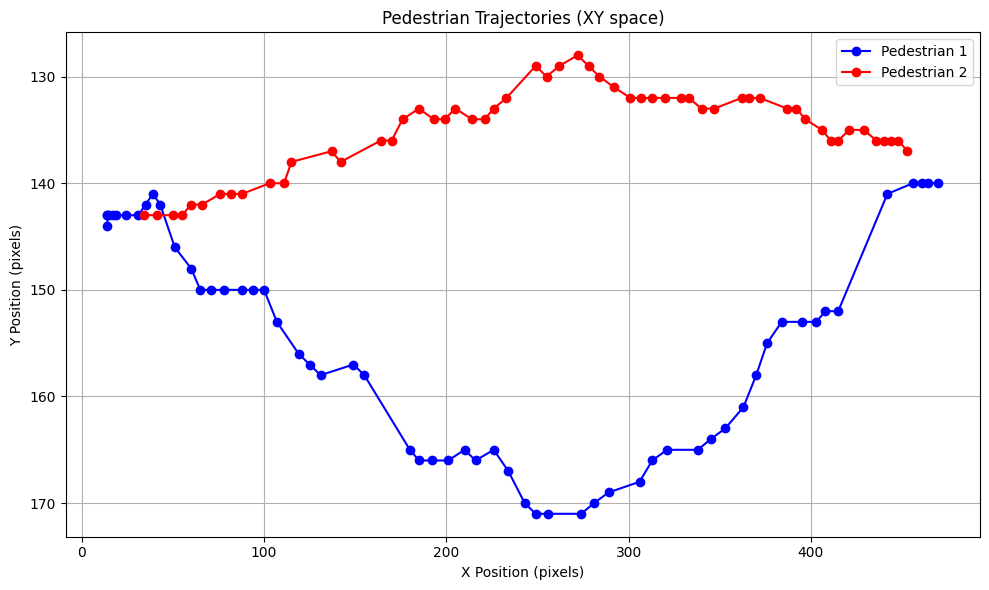

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data
x1 = np.load("x_pos_1.npy")
y1 = np.load("y_pos_1.npy")
x2 = np.load("x_pos_2.npy")
y2 = np.load("y_pos_2.npy")
times = np.load("times.npy")

# -----------------------
# Plot 1: X-Y Trajectories
# -----------------------
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, 'o-', label="Pedestrian 1", color='blue')
plt.plot(x2, y2, 'o-', label="Pedestrian 2", color='red')
plt.gca().invert_yaxis()  # Match image coordinates (origin at top-left)
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.title("Pedestrian Trajectories (XY space)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

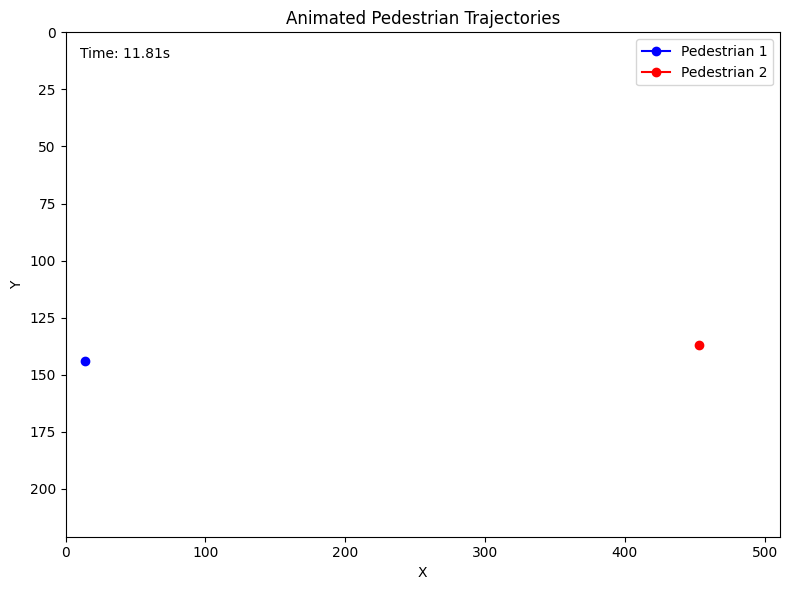

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load saved positions and times
x1 = np.load("x_pos_1.npy")
y1 = np.load("y_pos_1.npy")
x2 = np.load("x_pos_2.npy")
y2 = np.load("y_pos_2.npy")
times = np.load("times.npy")

# Match length (sometimes one list may be longer)
length = min(len(x1), len(x2), len(times))
x1, y1, x2, y2, times = x1[:length], y1[:length], x2[:length], y2[:length], times[:length]

# Setup figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, max(max(x1), max(x2)) + 50)
ax.set_ylim(0, max(max(y1), max(y2)) + 50)
ax.invert_yaxis()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Animated Pedestrian Trajectories")

# Initialize lines
line1, = ax.plot([], [], 'bo-', label="Pedestrian 1")
line2, = ax.plot([], [], 'ro-', label="Pedestrian 2")
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.legend()

# Animation update function
def update(frame):
    line1.set_data(x1[:frame+1], y1[:frame+1])
    line2.set_data(x2[:frame+1], y2[:frame+1])
    time_text.set_text(f"Time: {times[frame]:.2f}s")
    return line1, line2, time_text

ani = animation.FuncAnimation(fig, update, frames=length, interval=125, blit=True)
plt.tight_layout()
plt.show()


In [ ]:
ani.save("animated_trajectories.mp4", writer="ffmpeg", fps=8)
# or for GIF:
# ani.save("animated_trajectories.gif", writer="pillow", fps=8)


In [ ]:
import numpy as np
import csv

# Load saved arrays
x1 = np.load("x_pos_1.npy")
y1 = np.load("y_pos_1.npy")
x2 = np.load("x_pos_2.npy")
y2 = np.load("y_pos_2.npy")
times = np.load("times.npy")

# Step 1: Match array lengths
min_len = min(len(x1), len(x2), len(y1), len(y2), len(times))
x1, y1, x2, y2, times = x1[:min_len], y1[:min_len], x2[:min_len], y2[:min_len], times[:min_len]

# Step 2: Compute velocity
def compute_velocity(x, t):
    vx = np.zeros_like(x, dtype=float)
    delta_x = np.diff(x)
    delta_t = np.diff(t)
    valid = min(len(delta_x), len(delta_t))
    vx[1:1+valid] = delta_x[:valid] / delta_t[:valid]
    return vx

vx1 = compute_velocity(x1, times)
vx2 = compute_velocity(x2, times)
vy1 = np.zeros_like(vx1)
vy2 = np.zeros_like(vx2)

# Targets (static for now)
target_0 = (9, 3)
target_1 = (1, 3)
heuristic = 3
active = 1

# Step 3: Save to CSV
output_path = "formatted_trajectory.csv"
with open(output_path, "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        "time", "step", "agent_id", "x", "y", "vx", "vy",
        "target_x", "target_y", "distance_to_target", "heuristic", "active"
    ])
    for i in range(min_len):
        # Agent 0
        dist0 = ((target_0[0] - x1[i])**2 + (target_0[1] - y1[i])**2)**0.5
        writer.writerow([
            round(times[i], 2), i, 0, round(x1[i], 6), y1[i],
            round(vx1[i], 6), vy1[i], target_0[0], target_0[1],
            round(dist0, 6), heuristic, active
        ])
        # Agent 1
        dist1 = ((target_1[0] - x2[i])**2 + (target_1[1] - y2[i])**2)**0.5
        writer.writerow([
            round(times[i], 2), i, 1, round(x2[i], 6), y2[i],
            round(vx2[i], 6), vy2[i], target_1[0], target_1[1],
            round(dist1, 6), heuristic, active
        ])

print(f"✅ Trajectory CSV saved to: {output_path}")


✅ Trajectory CSV saved to: formatted_trajectory.csv


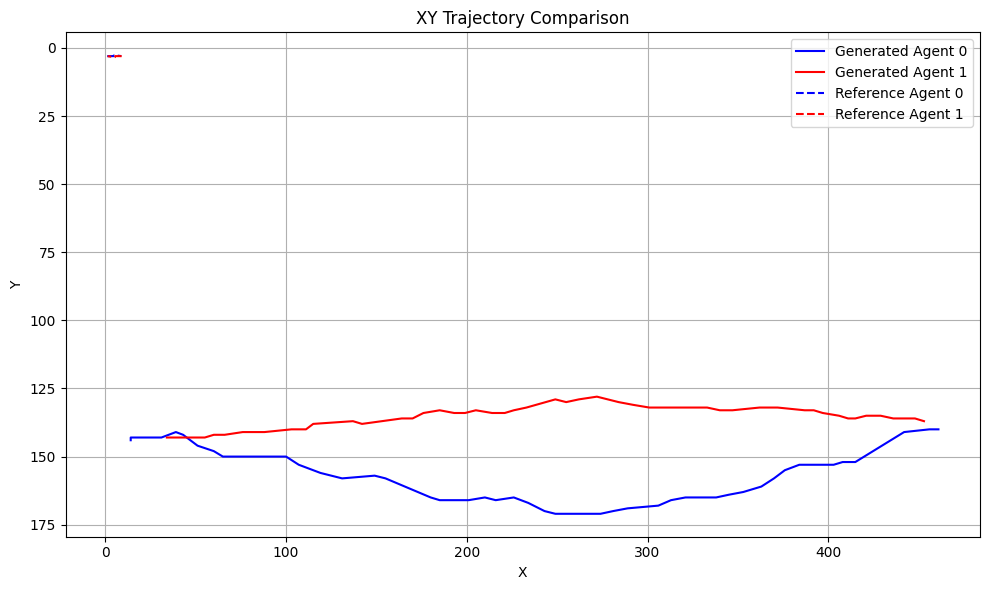

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both CSVs
gen_df = pd.read_csv("formatted_trajectory.csv")
ref_df = pd.read_csv("target_focused_trajectories.csv")  # Rename if needed

# Filter agents
gen_0 = gen_df[gen_df["agent_id"] == 0]
gen_1 = gen_df[gen_df["agent_id"] == 1]
ref_0 = ref_df[ref_df["agent_id"] == 0]
ref_1 = ref_df[ref_df["agent_id"] == 1]

# --------- Plot XY Trajectories ---------
plt.figure(figsize=(10, 6))
plt.plot(gen_0["x"], gen_0["y"], 'b-', label="Generated Agent 0")
plt.plot(gen_1["x"], gen_1["y"], 'r-', label="Generated Agent 1")
plt.plot(ref_0["x"], ref_0["y"], 'b--', label="Reference Agent 0")
plt.plot(ref_1["x"], ref_1["y"], 'r--', label="Reference Agent 1")
plt.gca().invert_yaxis()

plt.title("XY Trajectory Comparison")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("formatted_trajectory.csv")

# Group by agent_id
grouped = df.groupby("agent_id")

# Extract initial and final positions for each agent
for agent_id, group in grouped:
    initial = group.iloc[0]
    final = group.iloc[-1]

    print(f"\nAgent {agent_id}:")
    print(f"  Initial Position: x = {initial['x']}, y = {initial['y']}, time = {initial['time']}")
    print(f"  Final Position:   x = {final['x']}, y = {final['y']}, time = {final['time']}")



Agent 0:
  Initial Position: x = 14.0, y = 144.0, time = 11.81
  Final Position:   x = 461.0, y = 140.0, time = 23.67

Agent 1:
  Initial Position: x = 453.0, y = 137.0, time = 11.81
  Final Position:   x = 34.0, y = 143.0, time = 23.67
